## NN performance of a new DataGenerator considering both, the classical Keras augmentation algorithm and albumentations.

In [1]:
import sys
sys.path.insert(0, '../') #to load FileDataGenerator

In [2]:
from FileDataGenerator import FileDataGen 
import numpy as np
import skimage.io
import os
from keras.preprocessing.image import ImageDataGenerator #In order to compare the new class
import time
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
from keras import Input, optimizers, Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

In [4]:
def get_model(img_shape):
    
    entrada = Input(shape=img_shape)
    
    conv = Conv2D(filters=32, kernel_size=3, activation='relu', name='Conv2D_1')(entrada)
    maxpool = MaxPooling2D(pool_size=2, name='Maxpool_1')(conv)
    
    conv = Conv2D(filters=64, kernel_size=3, activation='relu', name='Conv2D_2')(maxpool)
    maxpool = MaxPooling2D(pool_size=2, name='Maxpool_2')(conv)
    
    conv = Conv2D(filters=128, kernel_size=3, activation='relu', name='Conv2D_3')(maxpool)
    maxpool = MaxPooling2D(pool_size=2, name='Maxpool_3')(conv)
    
    conv = Conv2D(filters=128, kernel_size=3, activation='relu', name='Conv2D_4')(maxpool)
    maxpool = MaxPooling2D(pool_size=2, name='Maxpool_4')(conv)
    
    drop = Dropout(rate=0.5)(maxpool)
    
    flat = Flatten(name='Flatten')(drop)
    dense = Dense(units=512, activation='relu', name='Dense')(flat)
    
    output = Dense(units=1, activation='sigmoid', name='Output')(dense)
    
    model = Model(entrada, output)
    
    model.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss = 'binary_crossentropy', metrics = ['acc'])
    
    return model
    

In [5]:
def plot_graphs(history):
    
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    
    epochs = range(1, len(acc)+1)
    
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation acc')
    plt.legend()
    
    plt.figure()
    
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()
    
    return    

In [6]:
DB_Train_Path = '/floyd/input/db1/small_dataset/train'
DB_Val_Path = '/floyd/input/db1/small_dataset/validation'

### Prepare Data

In [7]:
def Read_Directory(path):
    data=[]
    labels=[]
    for class_ in os.listdir(path):
        dat = [os.path.join(path, class_, img) for img in os.listdir(os.path.join(path, class_))]
        lab = [class_ for i in os.listdir(os.path.join(path, class_))]
        labels = labels+lab
        data = data + dat

    data = np.array(data)
    labels = np.array(labels)
    return data, labels

In [8]:
train_data, train_labels = Read_Directory(DB_Train_Path)
val_data, val_labels = Read_Directory(DB_Val_Path)

In [9]:
print('Training samples: {}'.format(len(train_data)))
print('Validation samples: {}'.format(len(val_data)))

Training samples: 2000
Validation samples: 1000


### Classical Keras ImageDataGenerator

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255,
                            rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True)
train_datagene = train_datagen.flow_from_directory(
    DB_Train_Path,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_datagene = val_datagen.flow_from_directory(
    DB_Val_Path,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [14]:
start_time = time.time()
model=get_model([150,150,3])
hist = model.fit_generator(train_datagene,
                          epochs=20,
                          steps_per_epoch=100,
                          validation_data = val_datagene,
                          validation_steps=50)
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/20
100/100 [==============================] - 42s 416ms/step - loss: 0.6920 - acc: 0.5253 - val_loss: 0.6744 - val_acc: 0.5489
Epoch 2/20
100/100 [==============================] - 38s 376ms/step - loss: 0.6792 - acc: 0.5641 - val_loss: 0.7022 - val_acc: 0.5108
Epoch 3/20
100/100 [==============================] - 38s 380ms/step - loss: 0.6679 - acc: 0.5947 - val_loss: 0.6491 - val_acc: 0.6079
Epoch 4/20
100/100 [==============================] - 38s 377ms/step - loss: 0.6510 - acc: 0.6112 - val_loss: 0.7203 - val_acc: 0.5495
Epoch 5/20
100/100 [==============================] - 38s 378ms/step - loss: 0.6391 - acc: 0.6259 - val_loss: 0.8088 - val_acc: 0.5286
Epoch 6/20
100/100 [==============================] - 40s 403ms/step - loss: 0.6264 - acc: 0.6444 - val_loss: 0.6388 - val_acc: 0.6079
Epoch 7/20
100/100 [==============================] - 38s 378ms/step - loss: 0.6093 - acc: 0.6638 - val_loss: 0.5892 - val_acc: 0.6827
Epoch 8/20
100/100 [==============================] - 3

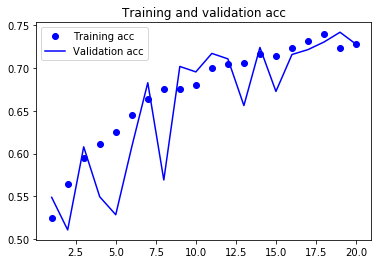

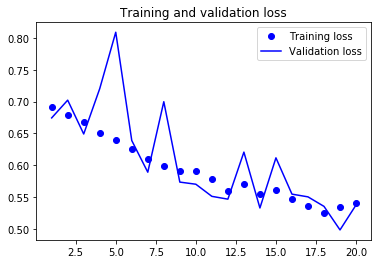

In [15]:
plot_graphs(hist.history)

### New FileDataGen --> Reading images not from a Path, but from a list of images (and labels)

In [16]:
#### Augmentation -> Classical augmentation (same as above)

In [19]:
train_datagen = FileDataGen(rescale=1./255,
                      rotation_range=40,
                      width_shift_range=0.2,
                      height_shift_range=0.2,
                      shear_range=0.2,
                      zoom_range=0.2,
                      horizontal_flip=True)

train_datagene = train_datagen.flow_from_filelist(train_data,
                                      train_labels,
                                      target_size=(150,150),
                                      batch_size=32,
                                      class_mode='binary')

val_datagen = FileDataGen(rescale=1./255)

val_datagene = val_datagen.flow_from_filelist(val_data,
                                      val_labels,
                                      target_size=(150,150),
                                      batch_size=32,
                                      class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [20]:
start_time = time.time()
model=get_model([150,150,3])
hist = model.fit_generator(train_datagene,
                          epochs=20,
                          steps_per_epoch=100,
                          validation_data = val_datagene,
                          validation_steps=50)
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/20
100/100 [==============================] - 42s 417ms/step - loss: 0.6885 - acc: 0.5284 - val_loss: 0.6769 - val_acc: 0.5704
Epoch 2/20
100/100 [==============================] - 38s 378ms/step - loss: 0.6803 - acc: 0.5575 - val_loss: 0.6601 - val_acc: 0.5747
Epoch 3/20
100/100 [==============================] - 38s 382ms/step - loss: 0.6640 - acc: 0.5841 - val_loss: 0.6412 - val_acc: 0.6129
Epoch 4/20
100/100 [==============================] - 38s 377ms/step - loss: 0.6457 - acc: 0.6159 - val_loss: 0.6168 - val_acc: 0.6630
Epoch 5/20
100/100 [==============================] - 38s 380ms/step - loss: 0.6372 - acc: 0.6294 - val_loss: 0.6055 - val_acc: 0.6567
Epoch 6/20
100/100 [==============================] - 38s 379ms/step - loss: 0.6197 - acc: 0.6534 - val_loss: 0.6066 - val_acc: 0.6585
Epoch 7/20
100/100 [==============================] - 38s 380ms/step - loss: 0.6077 - acc: 0.6625 - val_loss: 0.6242 - val_acc: 0.6095
Epoch 8/20
100/100 [==============================] - 3

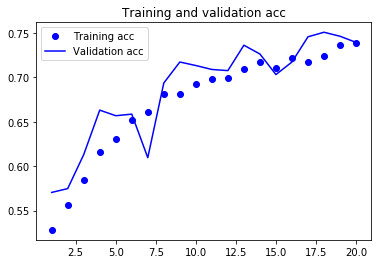

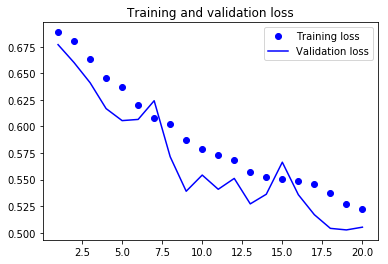

In [21]:
plot_graphs(hist.history)

In [ ]:
#### Augmentation -> Albumentations --> ShiftScaleRotate

In [22]:
train_datagen = FileDataGen(rescale=1./255,
                      aug_mode = 'ShiftScaleRotate')


train_datagene = train_datagen.flow_from_filelist(train_data,
                                      train_labels,
                                      target_size=(150,150),
                                      batch_size=32,
                                      class_mode='binary')

val_datagen = FileDataGen(rescale=1./255)

val_datagene = val_datagen.flow_from_filelist(val_data,
                                      val_labels,
                                      target_size=(150,150),
                                      batch_size=32,
                                      class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [23]:
start_time = time.time()
model=get_model([150,150,3])
hist = model.fit_generator(train_datagene,
                          epochs=20,
                          steps_per_epoch=100,
                          validation_data = val_datagene,
                          validation_steps=50)
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/20
100/100 [==============================] - 28s 283ms/step - loss: 0.6877 - acc: 0.5494 - val_loss: 0.6732 - val_acc: 0.5945
Epoch 2/20
100/100 [==============================] - 26s 260ms/step - loss: 0.6723 - acc: 0.5794 - val_loss: 0.6680 - val_acc: 0.5767
Epoch 3/20
100/100 [==============================] - 26s 265ms/step - loss: 0.6500 - acc: 0.6147 - val_loss: 0.6252 - val_acc: 0.6497
Epoch 4/20
100/100 [==============================] - 26s 261ms/step - loss: 0.6270 - acc: 0.6425 - val_loss: 0.6011 - val_acc: 0.6643
Epoch 5/20
100/100 [==============================] - 26s 264ms/step - loss: 0.5885 - acc: 0.6894 - val_loss: 0.5662 - val_acc: 0.7056
Epoch 6/20
100/100 [==============================] - 26s 263ms/step - loss: 0.5785 - acc: 0.7031 - val_loss: 0.5691 - val_acc: 0.6991
Epoch 7/20
100/100 [==============================] - 26s 262ms/step - loss: 0.5681 - acc: 0.7091 - val_loss: 0.5486 - val_acc: 0.7120
Epoch 8/20
100/100 [==============================] - 2

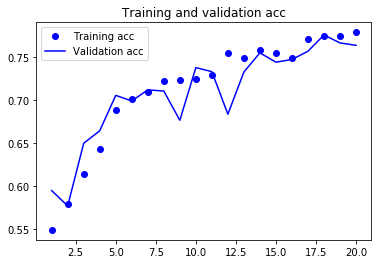

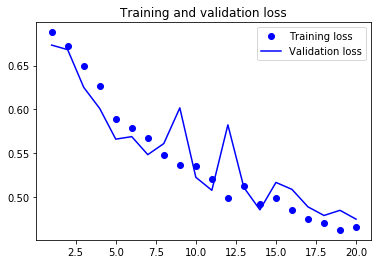

In [24]:
plot_graphs(hist.history)

In [25]:
#### Augmentation -> Albumentations --> IAAPerspective

In [26]:
train_datagen = FileDataGen(rescale=1./255,
                      aug_mode = 'IAAPerspective')

train_datagene = train_datagen.flow_from_filelist(train_data,
                                      train_labels,
                                      target_size=(150,150),
                                      batch_size=32,
                                      class_mode='binary')

val_datagen = FileDataGen(rescale=1./255)

val_datagene = val_datagen.flow_from_filelist(val_data,
                                      val_labels,
                                      target_size=(150,150),
                                      batch_size=32,
                                      class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [27]:
start_time = time.time()
model=get_model([150,150,3])
hist = model.fit_generator(train_datagene,
                          epochs=20,
                          steps_per_epoch=100,
                          validation_data = val_datagene,
                          validation_steps=50)
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/20
100/100 [==============================] - 30s 301ms/step - loss: 0.6886 - acc: 0.5238 - val_loss: 0.6729 - val_acc: 0.5952
Epoch 2/20
100/100 [==============================] - 28s 280ms/step - loss: 0.6776 - acc: 0.5775 - val_loss: 0.6568 - val_acc: 0.6095
Epoch 3/20
100/100 [==============================] - 28s 282ms/step - loss: 0.6652 - acc: 0.6062 - val_loss: 0.6352 - val_acc: 0.6459
Epoch 4/20
100/100 [==============================] - 28s 281ms/step - loss: 0.6495 - acc: 0.6209 - val_loss: 0.6083 - val_acc: 0.6624
Epoch 5/20
100/100 [==============================] - 28s 282ms/step - loss: 0.6361 - acc: 0.6344 - val_loss: 0.6337 - val_acc: 0.6282
Epoch 6/20
100/100 [==============================] - 28s 282ms/step - loss: 0.6192 - acc: 0.6606 - val_loss: 0.6282 - val_acc: 0.6308
Epoch 7/20
100/100 [==============================] - 28s 278ms/step - loss: 0.6046 - acc: 0.6665 - val_loss: 0.5667 - val_acc: 0.6985
Epoch 8/20
100/100 [==============================] - 2

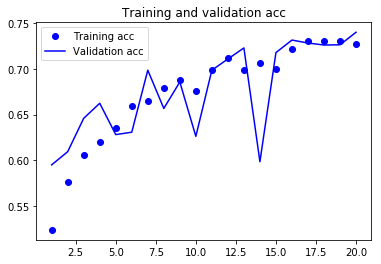

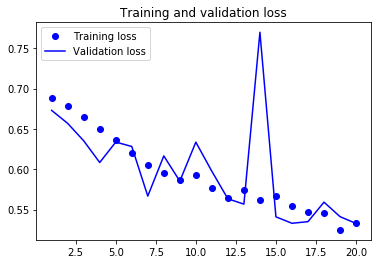

In [28]:
plot_graphs(hist.history)

In [29]:
#### Augmentation -> Albumentations --> MediumAug

In [30]:
train_datagen = FileDataGen(rescale=1./255,
                      aug_mode = 'MediumAug')

train_datagene = train_datagen.flow_from_filelist(train_data,
                                      train_labels,
                                      target_size=(150,150),
                                      batch_size=32,
                                      class_mode='binary')

val_datagen = FileDataGen(rescale=1./255)

val_datagene = val_datagen.flow_from_filelist(val_data,
                                      val_labels,
                                      target_size=(150,150),
                                      batch_size=32,
                                      class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [31]:
start_time = time.time()
model=get_model([150,150,3])
hist = model.fit_generator(train_datagene,
                          epochs=20,
                          steps_per_epoch=100,
                          validation_data = val_datagene,
                          validation_steps=50)
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/20
100/100 [==============================] - 35s 354ms/step - loss: 0.6923 - acc: 0.5259 - val_loss: 0.6861 - val_acc: 0.5013
Epoch 2/20
100/100 [==============================] - 32s 324ms/step - loss: 0.6839 - acc: 0.5416 - val_loss: 0.6687 - val_acc: 0.5844
Epoch 3/20
100/100 [==============================] - 32s 323ms/step - loss: 0.6732 - acc: 0.5909 - val_loss: 0.6789 - val_acc: 0.5717
Epoch 4/20
100/100 [==============================] - 33s 326ms/step - loss: 0.6677 - acc: 0.5888 - val_loss: 0.6473 - val_acc: 0.6160
Epoch 5/20
100/100 [==============================] - 33s 327ms/step - loss: 0.6565 - acc: 0.6028 - val_loss: 0.6470 - val_acc: 0.6256
Epoch 6/20
100/100 [==============================] - 32s 324ms/step - loss: 0.6545 - acc: 0.6106 - val_loss: 0.6308 - val_acc: 0.6398
Epoch 7/20
100/100 [==============================] - 33s 326ms/step - loss: 0.6452 - acc: 0.6200 - val_loss: 0.6137 - val_acc: 0.6521
Epoch 8/20
100/100 [==============================] - 3

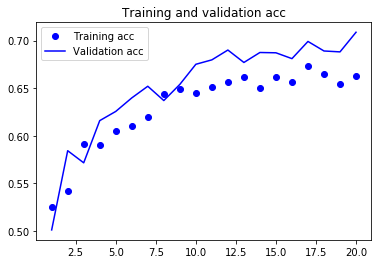

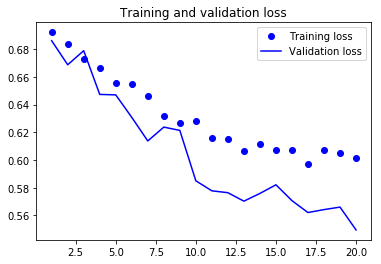

In [32]:
plot_graphs(hist.history)

In [33]:
#### Augmentation -> Albumentations --> StrongAug

In [34]:
train_datagen = FileDataGen(rescale=1./255,
                      aug_mode = 'StrongAug')

train_datagene = train_datagen.flow_from_filelist(train_data,
                                      train_labels,
                                      target_size=(150,150),
                                      batch_size=32,
                                      class_mode='binary')

val_datagen = FileDataGen(rescale=1./255)

val_datagene = val_datagen.flow_from_filelist(val_data,
                                      val_labels,
                                      target_size=(150,150),
                                      batch_size=32,
                                      class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [35]:
start_time = time.time()
model=get_model([150,150,3])
hist = model.fit_generator(train_datagene,
                          epochs=20,
                          steps_per_epoch=100,
                          validation_data = val_datagene,
                          validation_steps=50)
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/20


/usr/local/lib/python3.6/site-packages/albumentations/augmentations/functional.py:271: RuntimeWarning: invalid value encountered in true_divide
  return cv2.filter2D(img, -1, kernel / np.sum(kernel))


100/100 [==============================] - 51s 506ms/step - loss: 0.6922 - acc: 0.5122 - val_loss: 0.7142 - val_acc: 0.4981
Epoch 2/20
100/100 [==============================] - 44s 438ms/step - loss: 0.6810 - acc: 0.5591 - val_loss: 0.6791 - val_acc: 0.5296
Epoch 3/20
100/100 [==============================] - 45s 454ms/step - loss: 0.6641 - acc: 0.5959 - val_loss: 0.7473 - val_acc: 0.5108
Epoch 4/20
100/100 [==============================] - 45s 448ms/step - loss: 0.6484 - acc: 0.6197 - val_loss: 0.6331 - val_acc: 0.6385
Epoch 5/20
100/100 [==============================] - 45s 452ms/step - loss: 0.6301 - acc: 0.6462 - val_loss: 0.6249 - val_acc: 0.6478
Epoch 6/20
100/100 [==============================] - 45s 454ms/step - loss: 0.6143 - acc: 0.6634 - val_loss: 0.6000 - val_acc: 0.6791
Epoch 7/20
100/100 [==============================] - 44s 445ms/step - loss: 0.6104 - acc: 0.6597 - val_loss: 0.5881 - val_acc: 0.6920
Epoch 8/20
100/100 [==============================] - 45s 448ms/st

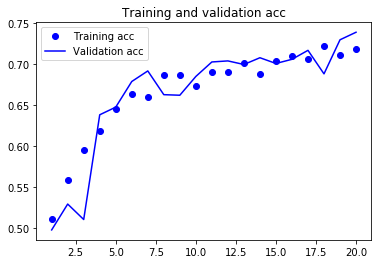

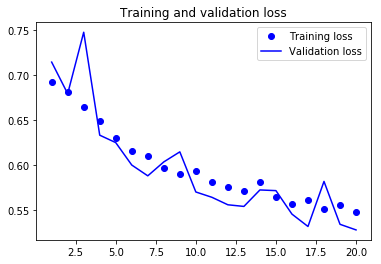

In [36]:
plot_graphs(hist.history)

In [ ]:
plot_graphs(hist.history)